# Applied Data Science Capstone: Coursera
#### Abhineet Sharma

This notebook is meant for applied data science capstone project at [Coursera](http://www.coursera.org). 

The data set is available at the path: `data-set/Data-Collisions.csv`.

In [1]:
!pip3 install folium
!pip3 install pandas
!pip3 install geopandas 
!pip3 install geojson
!pip3 install rtree
!pip3 install pygeos
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import folium
import geopandas as gpd 
import geojson as gj
import requests
from folium.plugins import HeatMap
print('Hello Capstone Project Course!')

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Hello Capstone Project Course!


## Business Understanding 
We are interested in finding out on a given day and a location in Seattle what is the possibility of an accident happening and how severe that could be. For example, if we are planning on visiting a certain place and we know the road, weather and light conditions, is it possible to know what is the possibility of having an accident so that we could be better prepared and take steps to avoid that. The stakeholders for this project includes the motor vehicle department and the residents. After successful completion of this project, DMV could be able to issue advisories to the commuters commuting to certain areas.


This translates to a multi-class classification problem where we intend to classify given data into different classes representing severity of the accident. A likelihood measure assigned to each classification would provide additional metric to advise commuters accordingly. We will analyze Seattle DMV's accident data and train various classification models and select the best fitting model. The model can then be used to predict possibility of an accident on a given day and location based on certain parameters. Let us explore the available data in the next section to build a better understanding of data and chalk out the necessary steps to clean and prepare data for training models. 


## Data Understanding
The data set is available in CSV format at `data-set/Data-Collisions.csv`. Let us first load the data and check out the basic attributes like shape, types of parameters, missing values etc. 

In [2]:
df = pd.read_csv('data-set/Data-Collisions.csv')
print(f'Data Shape: {df.shape[0]} rows x {df.shape[1]} columns')
df.head()

Data Shape: 194673 rows x 38 columns


SEVERITYCODE           X          Y  OBJECTID  INCKEY  COLDETKEY REPORTNO  \
0             2 -122.323148  47.703140         1    1307       1307  3502005   
1             1 -122.347294  47.647172         2   52200      52200  2607959   
2             1 -122.334540  47.607871         3   26700      26700  1482393   
3             1 -122.334803  47.604803         4    1144       1144  3503937   
4             2 -122.306426  47.545739         5   17700      17700  1807429   

    STATUS      ADDRTYPE   INTKEY  ... ROADCOND                LIGHTCOND  \
0  Matched  Intersection  37475.0  ...      Wet                 Daylight   
1  Matched         Block      NaN  ...      Wet  Dark - Street Lights On   
2  Matched         Block      NaN  ...      Dry                 Daylight   
3  Matched         Block      NaN  ...      Dry                 Daylight   
4  Matched  Intersection  34387.0  ...      Wet                 Daylight   

  PEDROWNOTGRNT  SDOTCOLNUM SPEEDING ST_COLCODE  \
0           NaN         NaN      NaN         10   
1           NaN   6354039.0      NaN         11   
2           NaN   4323031.0      NaN         32   
3           NaN         NaN      NaN         23   
4           NaN   4028032.0      NaN         10   

                                          ST_COLDESC  SEGLANEKEY  \
0                                  Entering at angle           0   
1  From same direction - both going straight - bo...           0   
2                             One parked--one moving           0   
3                   From same direction - all others           0   
4                                  Entering at angle           0   

   CROSSWALKKEY  HITPARKEDCAR  
0             0             N  
1             0             N  
2             0             N  
3             0             N  
4             0             N  

[5 rows x 38 columns]

We have 194673 rows with 38 parameters. From the sample data, it is evident that `SEVERITYCODE` is our target variable. Let us look at all the variables in the dataset and identify the ones relevant to the problem that could be explored further.

In [3]:
print(df.dtypes)

SEVERITYCODE        int64
X                 float64
Y                 float64
OBJECTID            int64
INCKEY              int64
COLDETKEY           int64
REPORTNO           object
STATUS             object
ADDRTYPE           object
INTKEY            float64
LOCATION           object
EXCEPTRSNCODE      object
EXCEPTRSNDESC      object
SEVERITYCODE.1      int64
SEVERITYDESC       object
COLLISIONTYPE      object
PERSONCOUNT         int64
PEDCOUNT            int64
PEDCYLCOUNT         int64
VEHCOUNT            int64
INCDATE            object
INCDTTM            object
JUNCTIONTYPE       object
SDOT_COLCODE        int64
SDOT_COLDESC       object
INATTENTIONIND     object
UNDERINFL          object
WEATHER            object
ROADCOND           object
LIGHTCOND          object
PEDROWNOTGRNT      object
SDOTCOLNUM        float64
SPEEDING           object
ST_COLCODE         object
ST_COLDESC         object
SEGLANEKEY          int64
CROSSWALKKEY        int64
HITPARKEDCAR       object
dtype: objec

Refering to the data set's metadata, we identify the following columns useful for our analysis.
- `SEVERITYCODE` : Target variable(Categorical)
    - `0`: Unknown
    - `1`: Property Damage
    - `2`: Injury
    - `2b`: Serious Injury
    - `3`: Fatality
- `X` & `Y`: Refer to the location of the incident. 
- `OBJECTID`: ESRI Unique identifier. Can be dropped. 
- `INCKEY`, `COLDETKEY` & `REPORTNO` are ids not relevant to our analysis and can be dropped. 
- `STATUS` is a categorical variable with two values:
    - `Matched`
    - `UnMatched`
   It seems like it is reported post accident and might not be very useful for our case. So this can be dropped as well.
- `ADDRTYPE`: Collision address type(Categorical)
    - `ALLEY`
    - `BLOCK`
    - `INTERSECTION`
    
- `INTKEY`: Key corresponding to the intersectio associated with the collision. 
- `LOCATION`: Actual location of the accident. This information is encoded into the `X` and `Y` columns. Thus, can be dropped.
- `EXCEPTRSNCODE` & `EXCEPTRSNDESC`: There is no information avaiable in metadata about these columns annd they seem to be sparsely populated in the data set. They can be dropped. 
- `SEVERITYCODE.1` & `SEVERITYDESC` can also be dropped. As we already have `SEVERITYCODE` column. Description also won't help us much in our predictio. Beore dropping `SEVERITYCODE.1` it might be worthwhile to look if it is actually duplicate or if there are some discrepancies in `SEVERITYCODE` and `SEVERITYCODE.1` column. 
- `COLLISIONTYPE`: Denotes the type of collisio. It is reported post accident, so can be dropped from our analysis.
- `PERSONCOUNT`, `PEDCOUNT`, `PEDCYLCOUNT`, `VEHCOUNT` are the counts of persons, pedestrians, bicycles and vehicles involved in the accident. This is also reported post accident but these columns contain the information of the types of vehicles involved and might be helpful in making predictions. For example, at a particular location there are more bike accidents than involving vehicles. May be you would feel safe going in a vehicle instead on a bicycle,. 
- `INCDATE` & `INCTM`: Incident date and time. Although this data directly won't help up in making prediciton. But it contains informationn about the season and the time of the day an accident occured. There is a possibility that there were more accidents reported in winters at a particular location. We may want to infer that information from these columns to see if it helps in predictions. 
- `JUNCTIONTYPE`: Category of junction where accident took place. This information might not be very handy in making predictions and might be dropped. 
- `SDOT_COLCODE` & `SDOT_COLDESC` are the codes and descriptions, respectively, assigned to the collision. This is reported post collision and might as well be dropped. 
- `INATTENTIONIND`: Whether or not the collision is due to inattention. Categorical variable with values `Y` and `N`.
- `UNDERINFL`: Whether or not the accident happened under influence of drugs or alcohol. This attribute is also reported post accident. There is no way of determining it before hand for our problem. Therefore, this can be dropped.
- `WEATHER`: Weather conditions during accident
- `ROADCOND`: Road conditions during accident
- `LIGHTCOND`: Light conditions during accident
- `PEDROWNOTGRNT`: Whether or not pedestrian right of way was granted or not. This is a post accident variable not useful for our prediction and can be dropped.
- `SDOTCOLNUM`: A number given to colision by SDOT. Can be dropped. 
- `SPEEDING`: Whether or not speeding was factor in collision. This is also a post accident variable and not useful for our prediction. It can be dropped.
- `ST_COLCODE` & `ST_COLDESC`: Code and description from state defined codes. Can be dropped. 
- `SEGLANEKEY`: A key for the lane in which collision occurred. Not very useful to us. Can be dropped. 
- `CROSSWALKKEY`: A key for the crosswalk where collision occurred. Not very useful to us. Can be dropped. 
- `HTPARKEDCAR`: Whether or not a parked car was hit. 

Thus, from the metadata, following are the candidates to be dropped from our analysis as not being useful
- `INCKEY`, `COLDETKEY` & `REPORTNO`
- `OBJECTID`
- `STATUS`
- `EXCEPTRSNCODE` & `EXCEPTRSNDESC`
- `SEVERITYCODE.1` & `SEVERITYDESC`
- `COLLISIONTYPE`
- `JUNCTIONTYPE`
- `SDOTCOLCODE`, `SDOTCOLNUM` & `SDOTCOLDESC`
- `ST_COLCODE` & `ST_COLDESC`
- `INTKEY`
- `LOCATION`
- `UNDERINFL`
- `PEDROWNOTGRNT`
- `SEGLANEKEY`
- `CROSSWALKKEY`
- `SPEEDING`

Let us firt drop the above identified columns from the data frame. Before doing that, let us also check if `SEVERITYCODE` and `SEVERITYCODE.1` are actually duplicates. 

In [4]:
total_unmatching_values = (df["SEVERITYCODE"] != df["SEVERITYCODE.1"]).sum()
print(f'Total unmatching values: {total_unmatching_values}')

Total unmatching values: 0


Since there are no unmatching values in `SEVERITYCODE` and `SEVERITYCODE.1` columns. They can be considered duplicate and one of them can be dropped. 

In [5]:
df.drop(columns=["INCKEY", "COLDETKEY", "REPORTNO", "OBJECTID", "STATUS", "EXCEPTRSNCODE", "EXCEPTRSNDESC",
                "SEVERITYCODE.1", "SEVERITYDESC", "COLLISIONTYPE", "JUNCTIONTYPE", "SDOT_COLCODE", 
                "SDOTCOLNUM", "SDOT_COLDESC", "ST_COLCODE", "ST_COLDESC", "INTKEY", "LOCATION", "UNDERINFL",
                "PEDROWNOTGRNT", "CROSSWALKKEY", "SEGLANEKEY", "SPEEDING"], inplace=True)
total_records = df.shape[0]
independent_variables = df.shape[1] - 1 # subtract one for the target variable.
print(f'Total of {total_records} records with {independent_variables} independent variables')

Total of 194673 records with 14 independent variables


This leaves us with 22 columns. Let us now analyze each column to understand the distribution better and see how we can use the information in our prediction. 

### Severity Code

In [6]:
df["SEVERITYCODE"].value_counts(normalize=True, dropna=False)

1    0.701099
2    0.298901
Name: SEVERITYCODE, dtype: float64

Around 70.1% of the accidents are of severity `1` in the data and the rest 29.9% of the accidents are of severity `2`.

### Location(`X` & `Y`)

Since `X` & `Y` are lattitudes and longitudes. So merely describing them won't help us much in understanding the distribution of the data. So let us try and plot them on Seattle's map. We plot a heat map to look at the distribution of accidents across Seattle. We shall also analyze any missing values of `X` and `Y`.

**Note**:`X` is longitude and `Y` is lattitude.

In [7]:
total_missing_values = df[["X", "Y"]].isna().sum().sum()
print(f'There are total of {total_missing_values} missing values of X and Y')
heat_df_sev = df[["X", "Y"]].dropna()
print(f'After dropping na values for heat map we have {heat_df_sev.shape[0]} rows x {heat_df_sev.shape[1]} columns')

There are total of 10668 missing values of X and Y
After dropping na values for heat map we have 189339 rows x 2 columns


In [8]:
map_seattle = folium.Map(location=[47.6062, -122.3321], zoom_start=16)
# X is longitude and Y is lattitude.
heat_data = [[row['Y'],row['X']] for index, row in heat_df_sev.iterrows()]
HeatMap(heat_data).add_to(map_seattle)
map_seattle

From the heat map it is pretty evident that we have good coverage over all of Seattle. 

### ADDRTYPE

In [9]:
total_missing_addrtype = df["ADDRTYPE"].isna().sum()
print(f'There are {total_missing_addrtype} valus of ADDRTYPE column')
df["ADDRTYPE"].dropna().value_counts(normalize=True)

There are 1926 valus of ADDRTYPE column


Block           0.658511
Intersection    0.337593
Alley           0.003896
Name: ADDRTYPE, dtype: float64

We have 1926 missing values of `ADDRTYPE` column. `ADDRTYPE` is a categorical column that takes on `3` values:
- Block (65.85% of records)
- Intersection (33.76% of records)
- Alley (0.39% of records)

We have very few accidents reported in alley and mostly on blocks with a significant number on intersection as well. Address type information is encoded within the location attributes, therefore we could as well drop this column.

### `PERSONCOUNT`, `PEDCOUNT`, `PEDCYLCOUNT` & `VEHCOUNT`

In [10]:
count_df = df[["PERSONCOUNT", "PEDCOUNT", "PEDCYLCOUNT", "VEHCOUNT"]]
missing_vals = count_df.isna().sum(axis=0)
print(f'There are {missing_vals.sum()} missing values for either of the counts')
count_df.describe()

There are 0 missing values for either of the counts


PERSONCOUNT       PEDCOUNT    PEDCYLCOUNT       VEHCOUNT
count  194673.000000  194673.000000  194673.000000  194673.000000
mean        2.444427       0.037139       0.028391       1.920780
std         1.345929       0.198150       0.167413       0.631047
min         0.000000       0.000000       0.000000       0.000000
25%         2.000000       0.000000       0.000000       2.000000
50%         2.000000       0.000000       0.000000       2.000000
75%         3.000000       0.000000       0.000000       2.000000
max        81.000000       6.000000       2.000000      12.000000

We can say that on average 2 persons are involved in an accident in Seattle and around 2 vehicles involved independently of each other. We have an accident reported with 81 people involved and 12 vehicles involved. They seem like outliers but it could be one huge accident chain. Let us draw a box plot to see the distribution.  

<AxesSubplot:>

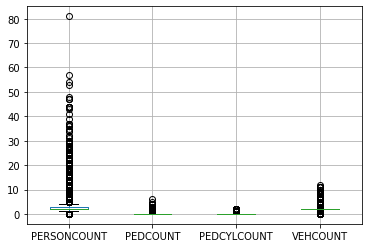

In [11]:
count_df.boxplot()

Most of the data is involved around less than 5 persons involded and 2 vehicles. There seem to be a lot of outliers. However, the counts reported are post metric from an accident and we would not need it directly in our analysis. Rather, we could convert it into a boolean field whether or not a person, pedestrian, cyclist or a vehicle was involved in the accident. Then depending a dependent variable `mode_of_transport` could be used in prediction. We will address this in our `Feature Engineering` section.  

### Conditions: Weather, Road, Light

In [12]:
conditions_df = df.loc[:, ["WEATHER", "ROADCOND", "LIGHTCOND"]]
print(f'There are a total of {conditions_df.shape[0]} rows x {conditions_df.shape[1]} columns')
actual_rows = conditions_df.shape[0]
missing_vals = conditions_df.isna().sum()
print(f'Missing Value Counts:\n{missing_vals}')
conditions_df.dropna(inplace=True)
print(f'After dropping na columns, we are left with {conditions_df.shape[0]} rows x {conditions_df.shape[1]} columns')
print(f'Number of rows dropped: {actual_rows - conditions_df.shape[0]}')

There are a total of 194673 rows x 3 columns
Missing Value Counts:
WEATHER      5081
ROADCOND     5012
LIGHTCOND    5170
dtype: int64
After dropping na columns, we are left with 189337 rows x 3 columns
Number of rows dropped: 5336


In [13]:
print(f'----------- WEATHER value counts -----------')
print(conditions_df["WEATHER"].value_counts(normalize=True))

print(f'\n----------- ROADCOND value counts -----------')
print(conditions_df['ROADCOND'].value_counts(normalize=True))

print(f'\n----------- LIGHTCOND value counts: -----------')
print(conditions_df['LIGHTCOND'].value_counts(normalize=True))

----------- WEATHER value counts -----------
Clear                       0.586299
Raining                     0.174910
Overcast                    0.146200
Unknown                     0.079430
Snowing                     0.004759
Other                       0.004352
Fog/Smog/Smoke              0.003005
Sleet/Hail/Freezing Rain    0.000597
Blowing Sand/Dirt           0.000290
Severe Crosswind            0.000132
Partly Cloudy               0.000026
Name: WEATHER, dtype: float64

----------- ROADCOND value counts -----------
Dry               0.656501
Wet               0.250437
Unknown           0.079388
Ice               0.006370
Snow/Slush        0.005276
Other             0.000692
Standing Water    0.000607
Sand/Mud/Dirt     0.000391
Oil               0.000338
Name: ROADCOND, dtype: float64

----------- LIGHTCOND value counts: -----------
Daylight                    0.613071
Dark - Street Lights On     0.255840
Unknown                     0.071069
Dusk                        0.031103


7.9% of the values are `Unknown`, they can also be dropped. For light conditions, there are 3 different categorizations in `Dark`. They can all be combined into single as `Dark`. Let us also look at the histogram of the values.

<AxesSubplot:>

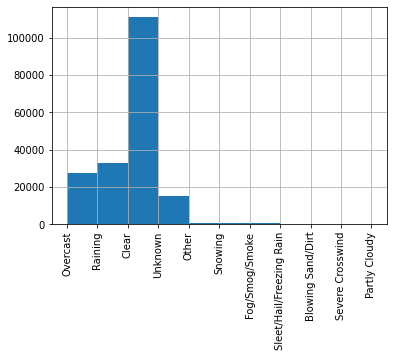

In [14]:
conditions_df["WEATHER"].hist(xrot=90)

Around 58.6% of the values are for `Clear` weather followed by `Raining` and `Overcast`. 

<AxesSubplot:>

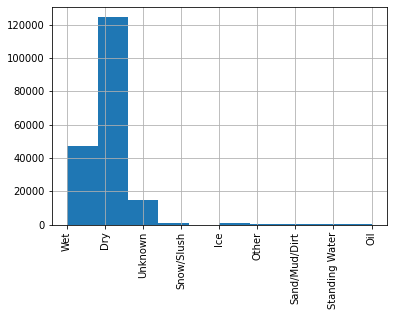

In [15]:
conditions_df["ROADCOND"].hist(xrot=90)

Around 65% of the values are for `Dry` weather followed by `Wet` and `Unknown`. 

<AxesSubplot:>

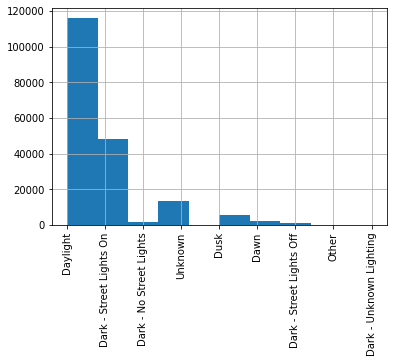

In [16]:
conditions_df["LIGHTCOND"].hist(xrot=90)

Around 61.3% value are for Daylight followed by `Dark: Street Lights On` and `Unknown`. 

### HITPARKEDCAR
Let us look more into `HITPARKEDCAR` distribution to see if we can utilize this variable as whether or not a commuter is planning to park a car on road. 

In [17]:
missing_vals = df["HITPARKEDCAR"].isna().sum()
print(f'Total missing values: {missing_vals}')
df["HITPARKEDCAR"].value_counts(normalize=True)

Total missing values: 0


N    0.962933
Y    0.037067
Name: HITPARKEDCAR, dtype: float64

The distribution is pretty much skewed with 96% of the records towards not hitting a parked car. So, we can 
drop the records with `HITPARKEDCAR='Y'` for the sake of convenience and simplicity.

### Key Takeaways

From the exploratory analysis of data, we have identified the following to be used for our prediction problem:
- `SEVERITYCODE`
- `X` & `Y`
- `PEDCOUNT`, `PEDCYLCOUNT`, `VEHCOUNT`
- `WEATHER`, `ROADCOND`, `LIGHTCOND`

However, we would need to do some kind of feature engineering to be able to utilize the above mentioned columns for our predicition problem. We discuss that in the next section called _Feature Engineering_.

#### Data Cleaning Takeaways
The following values need to be dropped: 
- `NA` or missing values for all the columns 
- `Unknown` for `WEATHER`, `ROADCOND`, `LIGHTCOND`
- Values where `HITPARKEDCAR` is `Y`.

Let us check if we have sufficient data for our analysis following the clean up. 


In [18]:
# wdf: working data frame
# WE keep HITPARKEDCAR for cleaning purposes and drop it later on.
wdf = df.loc[:, ["SEVERITYCODE", "X", "Y", "WEATHER", "ROADCOND", "LIGHTCOND", "HITPARKEDCAR", "PEDCOUNT", "PEDCYLCOUNT", "VEHCOUNT"]]
wdf.dropna(inplace=True)
wdf = wdf[wdf["HITPARKEDCAR"]=='N']
wdf.drop(columns=["HITPARKEDCAR"], inplace=True)
wdf = wdf[wdf["WEATHER"] != 'Unknown']
wdf = wdf[wdf["ROADCOND"] != 'Unknown']
wdf = wdf[wdf["LIGHTCOND"] != 'Unknown']
print(f'After clean up, we have {wdf.shape[0]} rows x {wdf.shape[1]} columns')

After clean up, we have 161913 rows x 9 columns


In [19]:
print('--------- SEVERITYCODE value counts: ---------')
print(wdf["SEVERITYCODE"].value_counts(normalize=True))

print('\n--------- WEATHER value counts: ---------')
print(wdf["WEATHER"].value_counts(normalize=True))

print('\n--------- ROADCOND value counts: ---------')
print(wdf["ROADCOND"].value_counts(normalize=True))

print('\n--------- LIGHTCOND value counts: ---------')
print(wdf["LIGHTCOND"].value_counts(normalize=True))

--------- SEVERITYCODE value counts: ---------
1    0.663677
2    0.336323
Name: SEVERITYCODE, dtype: float64

--------- WEATHER value counts: ---------
Clear                       0.639170
Raining                     0.191294
Overcast                    0.159042
Snowing                     0.004768
Fog/Smog/Smoke              0.003205
Other                       0.001445
Sleet/Hail/Freezing Rain    0.000661
Blowing Sand/Dirt           0.000247
Severe Crosswind            0.000142
Partly Cloudy               0.000025
Name: WEATHER, dtype: float64

--------- ROADCOND value counts: ---------
Dry               0.714680
Wet               0.272214
Ice               0.006429
Snow/Slush        0.004861
Standing Water    0.000587
Other             0.000574
Sand/Mud/Dirt     0.000346
Oil               0.000309
Name: ROADCOND, dtype: float64

--------- LIGHTCOND value counts: ---------
Daylight                    0.665716
Dark - Street Lights On     0.271905
Dusk                        0.033357


In [20]:
wdf.head()

SEVERITYCODE           X          Y   WEATHER ROADCOND  \
0             2 -122.323148  47.703140  Overcast      Wet   
1             1 -122.347294  47.647172   Raining      Wet   
2             1 -122.334540  47.607871  Overcast      Dry   
3             1 -122.334803  47.604803     Clear      Dry   
4             2 -122.306426  47.545739   Raining      Wet   

                 LIGHTCOND  PEDCOUNT  PEDCYLCOUNT  VEHCOUNT  
0                 Daylight         0            0         2  
1  Dark - Street Lights On         0            0         2  
2                 Daylight         0            0         3  
3                 Daylight         0            0         3  
4                 Daylight         0            0         2

## Feature Engineering
In the light of the data understanding, Let us formally define our prediction problem, 

_Given the area of commute, weather, road and light conditions and the mode of transport we would like to predict the severity of the accident._

For our problem, we would need to perform certain actions so that the data is consumable for our prediction models. 

- Location: `X` & `Y` categorized into Area
Considering the ease of use, we would like to calculate severity of an accident in a certain area as compared to a certain point on the earth. So, we would need to categorize the `X` and `Y` coordinates into certain areas we can train our models on. This could be administrative area or a smaller part of the city. This problem will be addressed in the data preparation section. 
- Dummy columns for categorical columns: `WEATHER`, `ROADCOND`, `LIGHTCOND`
- Convert the count columns as boolean values with a `TRUE` assigned to `value > 0` and `FALSE` assigned to `value == 0`. 

Let us import Seattle neighborhood data to map the location to a neighborhood.

In [21]:
url = 'https://raw.githubusercontent.com/seattleio/seattle-boundaries-data/master/data/neighborhoods.geojson'
r = requests.get(url, allow_redirects=True)

outfile=  'data-set/seattle-nbd.geojson'
open(outfile, mode='wb').write(r.content)
nbd = gpd.read_file(outfile)
unique_nbd = set(nbd['nhood'])
print(f'Neighborhoods: {unique_nbd}')

Neighborhoods: {'Kennydale', 'Talbot', 'Beacon Hill', 'West Wellington', 'Northwest Bellevue', 'West Hill', 'Central Area', 'Woodinville Heights', 'Valley Industrial', 'Totem Lake', 'Downtown', 'Wilburton', 'South Juanita', 'Fairwood', 'Factoria', 'Sammamish - East Lake HillS', 'Wallingford', 'Woodridge', 'Bitter Lake', 'Bryant', 'Rainier Valley', 'Interbay', 'Everest', 'Crown Hill', 'Laurelhurst', 'North Industrial', 'East Wellington', 'West Bellevue', 'Magnolia', 'North Beach - Blue Ridge', 'View Ridge', 'Crossroads', 'Lake City', 'Town Center', None, 'Green Lake', 'Market', 'Cascade', 'South Rose Hill', 'Broadview', 'West Seattle', 'Norkirk', 'Greenwood', 'Wedge', 'Industrial District', 'Benson', 'Central Houghton', 'South Park', 'North Juanita', 'Upper West Ridge', 'West Lake Hills', 'Cedar River', 'Lakeview', 'Capitol Hill', 'Ravenna', 'City Center', 'Sand Point', 'Somerset', 'Windermere', 'Georgetown', 'Ballard', 'Kingsgate', 'Northeast Bellevue', 'Lower West Ridge', 'Tourist Dis

In order to be able to map neighborhood data to location, we use spatial join. For this purpose, we create a geodata frame from our existing data frame.

In [22]:
from shapely.geometry import Point 

df['coords'] = df[['X', 'Y']].values.tolist()
df['coords'] = df['coords'].apply(Point)
gdf = gpd.GeoDataFrame(df, geometry='coords')
gdf.head()

SEVERITYCODE           X          Y      ADDRTYPE  PERSONCOUNT  PEDCOUNT  \
0             2 -122.323148  47.703140  Intersection            2         0   
1             1 -122.347294  47.647172         Block            2         0   
2             1 -122.334540  47.607871         Block            4         0   
3             1 -122.334803  47.604803         Block            3         0   
4             2 -122.306426  47.545739  Intersection            2         0   

   PEDCYLCOUNT  VEHCOUNT                 INCDATE                 INCDTTM  \
0            0         2  2013/03/27 00:00:00+00    3/27/2013 2:54:00 PM   
1            0         2  2006/12/20 00:00:00+00   12/20/2006 6:55:00 PM   
2            0         3  2004/11/18 00:00:00+00  11/18/2004 10:20:00 AM   
3            0         3  2013/03/29 00:00:00+00    3/29/2013 9:26:00 AM   
4            0         2  2004/01/28 00:00:00+00    1/28/2004 8:04:00 AM   

  INATTENTIONIND   WEATHER ROADCOND                LIGHTCOND HITPARKEDCAR  \
0            NaN  Overcast      Wet                 Daylight            N   
1            NaN   Raining      Wet  Dark - Street Lights On            N   
2            NaN  Overcast      Dry                 Daylight            N   
3            NaN     Clear      Dry                 Daylight            N   
4            NaN   Raining      Wet                 Daylight            N   

                        coords  
0  POINT (-122.32315 47.70314)  
1  POINT (-122.34729 47.64717)  
2  POINT (-122.33454 47.60787)  
3  POINT (-122.33480 47.60480)  
4  POINT (-122.30643 47.54574)

Now we apply spatial join to find the points within the neighborhood. 

In [23]:
# Align the CRS of location with the neighborhood CRS 
gdf.crs = nbd.crs
print('Running spatial join ...')
jdf = gpd.sjoin(gdf, nbd, how="left", op="intersects")
jdf.head()

Running spatial join ...


SEVERITYCODE           X          Y      ADDRTYPE  PERSONCOUNT  PEDCOUNT  \
0             2 -122.323148  47.703140  Intersection            2         0   
1             1 -122.347294  47.647172         Block            2         0   
2             1 -122.334540  47.607871         Block            4         0   
3             1 -122.334803  47.604803         Block            3         0   
4             2 -122.306426  47.545739  Intersection            2         0   

   PEDCYLCOUNT  VEHCOUNT                 INCDATE                 INCDTTM  ...  \
0            0         2  2013/03/27 00:00:00+00    3/27/2013 2:54:00 PM  ...   
1            0         2  2006/12/20 00:00:00+00   12/20/2006 6:55:00 PM  ...   
2            0         3  2004/11/18 00:00:00+00  11/18/2004 10:20:00 AM  ...   
3            0         3  2013/03/29 00:00:00+00    3/29/2013 9:26:00 AM  ...   
4            0         2  2004/01/28 00:00:00+00    1/28/2004 8:04:00 AM  ...   

  HITPARKEDCAR                       coords index_right  \
0            N  POINT (-122.32315 47.70314)        68.0   
1            N  POINT (-122.34729 47.64717)         NaN   
2            N  POINT (-122.33454 47.60787)        25.0   
3            N  POINT (-122.33480 47.60480)        25.0   
4            N  POINT (-122.30643 47.54574)        39.0   

                                           id     city county        nhood  \
0                Seattle:Northgate:Maple Leaf  Seattle   King    Northgate   
1                                         NaN      NaN    NaN          NaN   
2  Seattle:Downtown:Central Business District  Seattle   King     Downtown   
3  Seattle:Downtown:Central Business District  Seattle   King     Downtown   
4         Seattle:Beacon Hill:Mid-Beacon Hill  Seattle   King  Beacon Hill   

                      nested          area                       name  
0                 Maple Leaf  3.438047e+07                 Maple Leaf  
1                        NaN           NaN                        NaN  
2  Central Business District  9.477399e+06  Central Business District  
3  Central Business District  9.477399e+06  Central Business District  
4            Mid-Beacon Hill  5.262047e+07            Mid-Beacon Hill  

[5 rows x 24 columns]

In [24]:
# Create a working data frame retaining only the useful columns 
jdf.dtypes
retained_cols = ['SEVERITYCODE', 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE', 'INCDTTM', 'WEATHER', 'ROADCOND', 
                'LIGHTCOND', 'HITPARKEDCAR', 'nhood']
# Create a working data frame
wdf = jdf[retained_cols]
print(f'Remaining Rows: {wdf.shape[0]} x Cols: {wdf.shape[1]}')
print(f'Originally we had : {df.shape[0]} x {df.shape[1]}')
unq_nbd = set(wdf['nhood'])
print(f'Unique Neighborhoods: {unq_nbd}')

Remaining Rows: 194679 x Cols: 12
Originally we had : 194673 x 16
Unique Neighborhoods: {nan, 'Georgetown', 'Beacon Hill', 'Ballard', 'Greenwood', 'West Hill', 'Industrial District', 'Central Area', 'Roosevelt', 'North Beach - Blue Ridge', 'View Ridge', 'Magnolia', 'Phinney Ridge', 'South Park', 'Delridge', 'Downtown', 'Lake City', 'Fremont', None, 'University District', 'Wallingford', 'Bitter Lake', 'Bryant', 'Northgate', 'Capitol Hill', 'Rainier Valley', 'Green Lake', 'Ravenna', 'Interbay', 'Wedgwood', 'Crown Hill', 'Laurelhurst', 'Sand Point', 'Queen Anne', 'Seward Park', 'Cascade', 'Harbor Island', 'Windermere', 'Broadview', 'West Seattle'}


Let us explore the neighborhood data as well.

<AxesSubplot:>

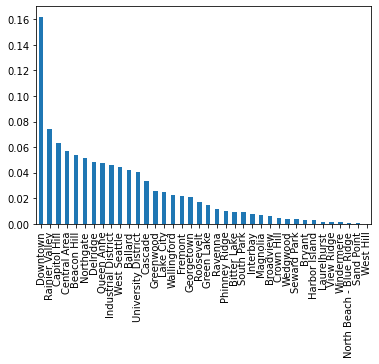

In [25]:
wdf['nhood'].value_counts(normalize=True).plot.bar()

Majority of the accidents have been reported in the downtown area followed by Rainier Valley and Capitol Hill respectively.

## Data Preparation

After data exploration and feature engineering, we prepare our data for modelling. We identified the following points to for data preparation from the previous section:
- Map locations to neighborhood
- Instead of counts have a boolean field to indicate if a pedestrian, cyclist or a vehicle involved. 
- Map times to the time of the day as in `morning`, `afternoon`, `evening` and `night`.
- Map dates to the seasons of the year as in `spring`, `summer`, `fall` and `winter`. 

Let us drop all the na values first. 

In [26]:
wdf.dropna(inplace=True)
print(f'After dropping na values we have, {wdf.shape[0]} rows x {wdf.shape[1]} columns')

After dropping na values we have, 182134 rows x 12 columns


The counts of pedestrian, cyclist or vehicle involved do not provide us a lot of value. Rather a boolean indicator for those columns does provide us some value, as we could check on the basis of mode of transport used. Let us convert those counts into a boolean indicator. Person count is encoded into the severity of the accident, thus it can be dropped.

In [27]:
wdf['PED'] = wdf['PEDCOUNT'] > 0
wdf['CYCLIST'] = wdf['PEDCYLCOUNT'] > 0
wdf['VEHICLE'] = wdf['VEHCOUNT'] > 0
print('-------- PED value counts ----------')
print(wdf['PED'].value_counts(normalize=True))

print('\n-------- CYCLIST value counts ----------')
print(wdf['CYCLIST'].value_counts(normalize=True))

print('\n-------- VEHICLE value counts ----------')
print(wdf['VEHICLE'].value_counts(normalize=True))


wdf.drop(columns=['PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT'], inplace=True)
wdf.head()

-------- PED value counts ----------
False    0.962539
True     0.037461
Name: PED, dtype: float64

-------- CYCLIST value counts ----------
False    0.970214
True     0.029786
Name: CYCLIST, dtype: float64

-------- VEHICLE value counts ----------
True     0.99894
False    0.00106
Name: VEHICLE, dtype: float64


SEVERITYCODE                 INCDATE                 INCDTTM   WEATHER  \
0             2  2013/03/27 00:00:00+00    3/27/2013 2:54:00 PM  Overcast   
2             1  2004/11/18 00:00:00+00  11/18/2004 10:20:00 AM  Overcast   
3             1  2013/03/29 00:00:00+00    3/29/2013 9:26:00 AM     Clear   
4             2  2004/01/28 00:00:00+00    1/28/2004 8:04:00 AM   Raining   
5             1  2019/04/20 00:00:00+00    4/20/2019 5:42:00 PM     Clear   

  ROADCOND LIGHTCOND HITPARKEDCAR        nhood    PED  CYCLIST  VEHICLE  
0      Wet  Daylight            N    Northgate  False    False     True  
2      Dry  Daylight            N     Downtown  False    False     True  
3      Dry  Daylight            N     Downtown  False    False     True  
4      Wet  Daylight            N  Beacon Hill  False    False     True  
5      Dry  Daylight            N      Ballard  False    False     True

Moving our attention to the date time part of data preparation, let us first map the hours to the part of the day and then map months to the seasons of the year. 

In [28]:
wdf.dtypes
# raw_data['Mycol'] =  pd.to_datetime(raw_data['Mycol'], format='%d%b%Y:%H:%M:%S.%f')
wdf.loc[:,'DATE_TIME'] = pd.to_datetime(wdf.loc[:, 'INCDTTM'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
# Drop the ones with missing time values 
wdf.dropna(inplace=True)
wdf['HOUR_OF_DAY'] = wdf.loc[:,'DATE_TIME'].dt.hour
wdf.head()
unq_hours = set(wdf.loc[:,'HOUR_OF_DAY'])
print(unq_hours)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}


In [29]:
wdf['DAY_PART'] = np.nan
wdf['DAY_PART'][(wdf['HOUR_OF_DAY'] >= 6) &  (wdf['HOUR_OF_DAY'] < 12)] = 'Morning'
wdf['DAY_PART'][(wdf['HOUR_OF_DAY'] >= 12) &  (wdf['HOUR_OF_DAY'] < 17)] = 'Afternoon'
wdf['DAY_PART'][(wdf['HOUR_OF_DAY'] >= 17) &  (wdf['HOUR_OF_DAY'] < 20)] = 'Evening'
wdf['DAY_PART'][wdf.loc[:, 'DAY_PART'].isna()] = 'Night'

In [30]:
wdf['SEASON'] = np.nan
wdf['MONTH'] = wdf.loc[:,'DATE_TIME'].dt.month
wdf['SEASON'][(wdf['MONTH'] >= 3) &  (wdf['MONTH'] <= 5)] = 'Spring'
wdf['SEASON'][(wdf['MONTH'] >= 6) &  (wdf['MONTH'] <= 8)] = 'Summer'
wdf['SEASON'][(wdf['MONTH'] >= 9) &  (wdf['MONTH'] <= 11)] = 'Fall'
wdf['SEASON'][wdf.loc[:, 'SEASON'].isna()] = 'Winter'

In [31]:
wdf.drop(columns= ["INCDATE", "INCDTTM", "DATE_TIME", "HOUR_OF_DAY", "MONTH"], inplace=True)
wdf.head()

SEVERITYCODE   WEATHER ROADCOND LIGHTCOND HITPARKEDCAR        nhood    PED  \
0             2  Overcast      Wet  Daylight            N    Northgate  False   
2             1  Overcast      Dry  Daylight            N     Downtown  False   
3             1     Clear      Dry  Daylight            N     Downtown  False   
4             2   Raining      Wet  Daylight            N  Beacon Hill  False   
5             1     Clear      Dry  Daylight            N      Ballard  False   

   CYCLIST  VEHICLE   DAY_PART  SEASON  
0    False     True  Afternoon  Spring  
2    False     True    Morning    Fall  
3    False     True    Morning  Spring  
4    False     True    Morning  Winter  
5    False     True    Evening  Spring

`HITPARKEDCAR` column is of type object, let us convert it to a boolean.

In [32]:
wdf["HITPARKEDCAR"][wdf.loc[:, "HITPARKEDCAR"] == 'Y'] = True
wdf["HITPARKEDCAR"][wdf.loc[:, "HITPARKEDCAR"] == 'N'] = False
wdf["HITPARKEDCAR"] = wdf["HITPARKEDCAR"].astype('bool')
wdf.dtypes

SEVERITYCODE     int64
WEATHER         object
ROADCOND        object
LIGHTCOND       object
HITPARKEDCAR      bool
nhood           object
PED               bool
CYCLIST           bool
VEHICLE           bool
DAY_PART        object
SEASON          object
dtype: object

Some of the classifications models might require dummies, so let us create another data frame that has the dummy values. 

In [33]:
wdf_dummies = pd.get_dummies(wdf)
wdf_dummies.head()

SEVERITYCODE  HITPARKEDCAR    PED  CYCLIST  VEHICLE  \
0             2         False  False    False     True   
2             1         False  False    False     True   
3             1         False  False    False     True   
4             2         False  False    False     True   
5             1         False  False    False     True   

   WEATHER_Blowing Sand/Dirt  WEATHER_Clear  WEATHER_Fog/Smog/Smoke  \
0                          0              0                       0   
2                          0              0                       0   
3                          0              1                       0   
4                          0              0                       0   
5                          0              1                       0   

   WEATHER_Other  WEATHER_Overcast  ...  nhood_West Seattle  nhood_Windermere  \
0              0                 1  ...                   0                 0   
2              0                 1  ...                   0                 0   
3              0                 0  ...                   0                 0   
4              0                 0  ...                   0                 0   
5              0                 0  ...                   0                 0   

   DAY_PART_Afternoon  DAY_PART_Evening  DAY_PART_Morning  DAY_PART_Night  \
0                   1                 0                 0               0   
2                   0                 0                 1               0   
3                   0                 0                 1               0   
4                   0                 0                 1               0   
5                   0                 1                 0               0   

   SEASON_Fall  SEASON_Spring  SEASON_Summer  SEASON_Winter  
0            0              1              0              0  
2            1              0              0              0  
3            0              1              0              0  
4            0              0              0              1  
5            0              1              0              0  

[5 rows x 80 columns]

## Modelling


Let us revisit the problem definition. Given certain conditions, we need to calculate the severity of an accident. From the data, we have a binary classification problem because there are only two classes available: `1` and `2`. `SEVERITYCODE` is our target variable and `WEATHER`, `ROADCOND`, `LIGHTCOND`, `HITPARKEDCAR`, `nhood`, `PED`, `CYCLIST`, `VEHICLE`, `DAY_PART` and `SEASON` are the independent variables.

Let us first divide the data into a training and testing data and do a `70:30` train:test split.

In [34]:
from sklearn.model_selection import train_test_split
y = wdf_dummies['SEVERITYCODE']
X = wdf_dummies.iloc[:, 1:]
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (110237, 79) (110237,)
Test set: (47245, 79) (47245,)


In [35]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### KNN

In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import time

Ks = 8
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    print(f'For k={n}')
    start_time = time.time()
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    print(f'\tTime taken: {time.time() - start_time} seconds')
    pred_time = time.time()
    yhat=neigh.predict(X_test)
    print(f'\tPrediction Time: {time.time() - pred_time} seconds')
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

For k=1
	Time taken: 29.972219944000244 seconds
	Prediction Time: 260.02201318740845
For k=2
	Time taken: 29.072439193725586 seconds
	Prediction Time: 274.8940317630768
For k=3
	Time taken: 29.310518980026245 seconds
	Prediction Time: 296.90652108192444
For k=4
	Time taken: 29.807021141052246 seconds
	Prediction Time: 308.89261269569397
For k=5
	Time taken: 32.81218099594116 seconds
	Prediction Time: 310.42315912246704
For k=6
	Time taken: 28.453959941864014 seconds
	Prediction Time: 313.4266219139099
For k=7
	Time taken: 30.808481693267822 seconds
	Prediction Time: 327.11331605911255


array([0.63723145, 0.70039158, 0.66716055, 0.70581014, 0.67632554,
       0.70161922, 0.68898296])

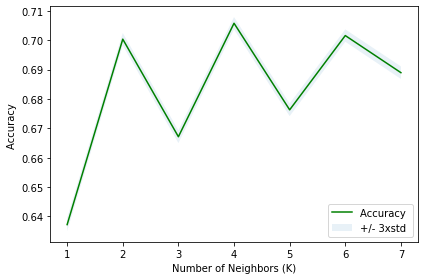

In [37]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [38]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.7058101386390094 with k= 4


In [39]:
optimal_k = mean_acc.argmax()+1
neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
yhat=neigh.predict(X_test)

In [41]:
print(f'Jaccard Similarity: {jaccard_score(y_test, yhat)}')
print(f'F1 Score: {f1_score(y_test, yhat)}')

Jaccard Similarity: 0.6621447622551274
F1 Score: 0.7967353714206669


### Decision Trees

In [43]:
from sklearn.tree import DecisionTreeClassifier
y_dt = wdf['SEVERITYCODE']
X_dt = wdf.iloc[:, 1:]
X_trainset, X_testset, y_trainset, y_testset = train_test_split( X, y, test_size=0.3, random_state=4)

depths = 10
dt_mean_acc = np.zeros((depths-1))
dt_std_acc = np.zeros((depths-1))
ConfustionMx = [];
for n in range(1,depths):
    print(f'For depth={n}')
    #Train Model and Predict  
    dt = DecisionTreeClassifier(criterion="entropy", max_depth = n).fit(X_trainset,y_trainset)
    yhat=dt.predict(X_testset)
    dt_mean_acc[n-1] = metrics.accuracy_score(y_testset, yhat)
    dt_std_acc[n-1]=np.std(yhat==y_testset)/np.sqrt(yhat.shape[0])

dt_mean_acc

For depth=1
For depth=2
For depth=3
For depth=4
For depth=5
For depth=6
For depth=7
For depth=8
For depth=9


array([0.72337814, 0.74606837, 0.74606837, 0.7459837 , 0.74596254,
       0.7458567 , 0.74568737, 0.74566621, 0.74572971])

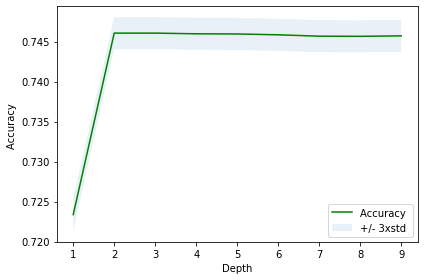

In [44]:
plt.plot(range(1,depths),dt_mean_acc,'g')
plt.fill_between(range(1,depths),dt_mean_acc - 1 * dt_std_acc, dt_mean_acc + 1 * dt_std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Depth')
plt.tight_layout()
plt.show()

In [45]:
print( "The best accuracy was with", mean_acc.max(), "with depth=", mean_acc.argmax()+1) 

The best accuracy was with 0.7058101386390094 with depth= 4


In [46]:
optimal_depth = mean_acc.argmax()+1
dt = DecisionTreeClassifier(criterion="entropy", max_depth = optimal_depth).fit(X_trainset,y_trainset)
yhat=dt.predict(X_testset)

Confusion matrix, without normalization
[[32367   359]
 [11642  2877]]


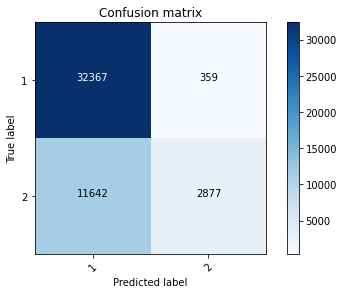

In [47]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_testset, yhat, labels=[1,2])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['1','2'],normalize= False,  title='Confusion matrix')

In [49]:
print(f'Jaccard Similarity: {jaccard_score(y_testset, yhat)}')
print(f'F1 Score: {f1_score(y_testset, yhat)}')

Jaccard Similarity: 0.7295122610890732
F1 Score: 0.8436046132794683


### Logistic Regression

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, solver='liblinear')

In [64]:
yhat = LR.predict(X_test)
print(yhat)
yhat_prob = LR.predict_proba(X_test)
print(yhat_prob)
print(f'Accuracy: {metrics.accuracy_score(y_test, yhat)}')

[1 1 1 ... 1 1 1]
[[0.71 0.29]
 [0.75 0.25]
 [0.7  0.3 ]
 ...
 [0.77 0.23]
 [0.71 0.29]
 [0.68 0.32]]
Accuracy: 0.7454757117155254


In [52]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           1       0.73      0.99      0.84     32726
           2       0.89      0.20      0.32     14519

    accuracy                           0.75     47245
   macro avg       0.81      0.59      0.58     47245
weighted avg       0.78      0.75      0.68     47245



Confusion matrix, without normalization
[[32375     0]
 [    0     0]]


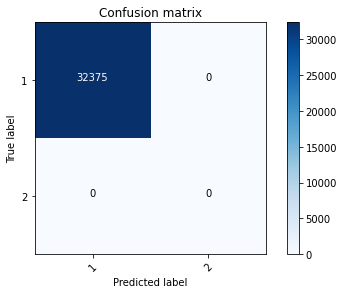

In [53]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['1','2'],normalize= False,  title='Confusion matrix')

In [55]:
print(f'Jaccard Similarity: {jaccard_score(y_test, yhat)}')
print(f'F1 Score: {f1_score(y_test, yhat)}')
print(f'Log Loss: {log_loss(y_test, yhat_prob)}')

Jaccard Similarity: 0.7291666666666666
F1 Score: 0.8433734939759036
Log Loss: 0.538652329634663


### SVM

In [56]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
start_time = time.time()
clf.fit(X_train, y_train) 
print(f'Time taken : {time.time() - start_time} seconds')

Time taken : 2801.295485973358 seconds


In [57]:
yhat = clf.predict(X_test)
yhat [0:5]

array([1, 1, 1, 1, 1])

              precision    recall  f1-score   support

           1       0.74      0.99      0.84     32726
           2       0.89      0.20      0.32     14519

    accuracy                           0.75     47245
   macro avg       0.81      0.59      0.58     47245
weighted avg       0.78      0.75      0.68     47245

Confusion matrix, without normalization
[[2881    0]
 [   0    0]]


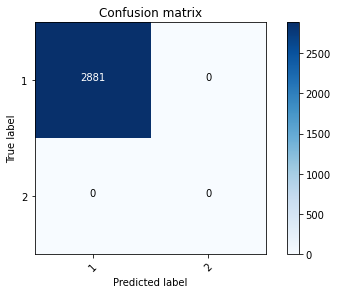

In [58]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[2,4])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['1','2'],normalize= False,  title='Confusion matrix')

In [62]:
print(f'Jaccard Similarity: {jaccard_score(y_test, yhat)}')
print(f'F1 Score: {f1_score(y_test, yhat)}')
print(f'Accuracy: {metrics.accuracy_score(y_test, yhat)}')

Jaccard Similarity: 0.7295780362456046
F1 Score: 0.8436485905305549
Accuracy: 0.7460683670229654


## Evaluation

In the previous section, we trained the following models:
- KNN: with k=4, gives the best results on the test set.
- Decision Tree: At depth = 2, gives the best results on the test set.
- Logistic Regression 
- SVM with RBF Kernel

Following table summarizes the scores for the above models on test set from a 70:30 data split. 

| Model | Accuracy | Jaccard Similarity score | F1-Score | Log Loss Score |
| -- | -- | -- | -- | -- | 
| KNN | 70.58% | 66.21% | 79.67% | - |
| Decision Tree | 70.58% | 72.95% | 84.36% | - |
| Logistic Regression | 74.54% | 72.92%  | 84.33% | 53.86% |
| SVM | 74.60% | 72.95% | 84.36% | - |


SVM has the best accuracy, jaccard similarity and F1-Score. SVM is the model of choice.